In [573]:
# Import required modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

%matplotlib inline

# SECTION 1 - Camera Calibration

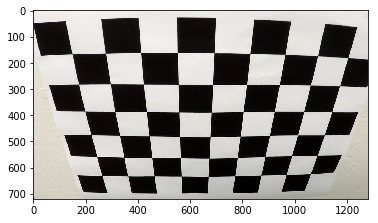

In [574]:
# Read in an example calibration image
img = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)

Processing image camera_cal\calibration1.jpg
Processing image camera_cal\calibration10.jpg
Corners found for image camera_cal\calibration10.jpg
Processing image camera_cal\calibration11.jpg
Corners found for image camera_cal\calibration11.jpg
Processing image camera_cal\calibration12.jpg
Corners found for image camera_cal\calibration12.jpg
Processing image camera_cal\calibration13.jpg
Corners found for image camera_cal\calibration13.jpg
Processing image camera_cal\calibration14.jpg
Corners found for image camera_cal\calibration14.jpg
Processing image camera_cal\calibration15.jpg
Corners found for image camera_cal\calibration15.jpg
Processing image camera_cal\calibration16.jpg
Corners found for image camera_cal\calibration16.jpg
Processing image camera_cal\calibration17.jpg
Corners found for image camera_cal\calibration17.jpg
Processing image camera_cal\calibration18.jpg
Corners found for image camera_cal\calibration18.jpg
Processing image camera_cal\calibration19.jpg
Corners found for 

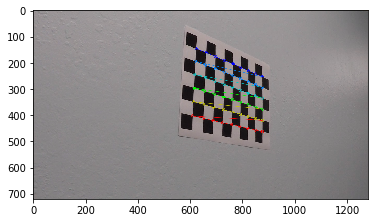

In [575]:
# Take in all the pictures of the chess board from the camera_cal folder.
# Use these pictures to calibrate the camera by creating the distortion matrix.

# Initialise empty arrays to hold
# Object points - these are the real location of the points
# image points - these are the location of the points in the distorted image.
object_points = [] # 3d space
image_points = [] # 2d space

# These object points are always the same as it's always a chess board.
objp = np.zeros((num_rows*num_cols, 3), np.float32)
objp[:,:2] = np.mgrid[0:num_cols, 0:num_rows].T.reshape(-1,2)

# Set the size of the chess board used in the calibration
# Remember to only count inside corners.
num_rows = 6
num_cols = 9 

images = glob.glob('camera_cal/calibration*.jpg')
for image in images:
    
    print('Processing image {}'.format(image))
    
    input_image = cv2.imread(image)
    
    # Convert the grayscale for finding the corners.
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    
    # Find the chess board in the pictures
    ret, corners = cv2.findChessboardCorners(gray_image, (num_cols, num_rows), None)

    # Append points for each image
    if ret == True:
        print('Corners found for image {}'.format(image))
        image_points.append(corners)
        object_points.append(objp)

        # Option to draw the corners onto the image. Good to check and for write up.
        found_corners = cv2.drawChessboardCorners(input_image, (num_cols, num_rows), corners, ret)
        plt.imshow(found_corners)


Could not find corners for calibration4, calibration5 and calibration1

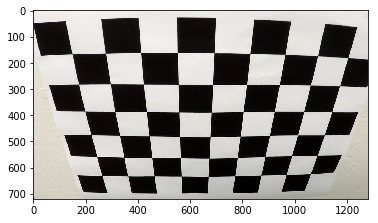

In [590]:
# Use the points found above for calibration.
image = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(image)

In [591]:
def undistort_image(image, object_points, image_points):
    # Now calcualte the distortion coef and matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image.shape[1:], None, None )
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted, mtx, dist

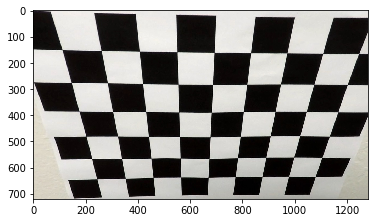

In [592]:
undistorted, mtx, dist = undistort_image(image, object_points, image_points)

plt.imshow(undistorted)

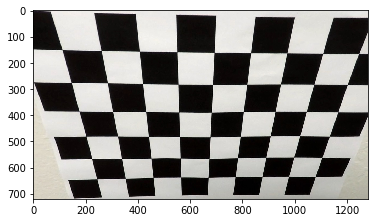

In [593]:
plt.imshow(undistorted)

In [594]:
cv2.imwrite('write_up_images\chessboard_undistorted.jpg', undistorted)

True

False

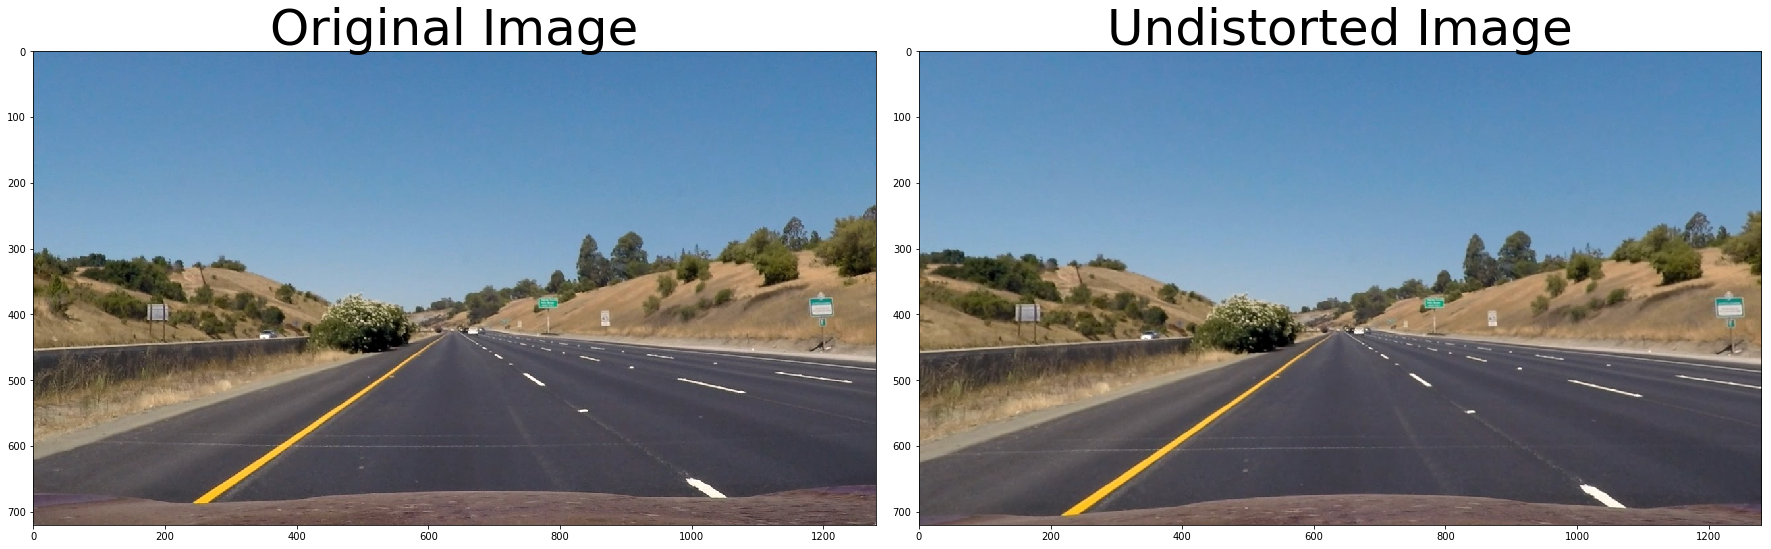

In [597]:
# Lets check the distortion change on  a real image. 
image = mpimg.imread('test_images/straight_lines1.jpg')
undistorted, mtx, dist = undistort_image(image, object_points, image_points)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('write_up_images\road_undistorted.jpg', undistorted)

The undistort isn't really obvious. The camera doesn't have a great deal of distortion associated with it. You can see a small amount of change at the very edges. The road sign on the right hand side is now closer to the right hand edge. 

# Section 2 - Thresholded binary image (color transforms and gradients)

In [329]:
# Gradient thresholds first

# Using the starter code from the tutorials

# Apply gradient threshold separately for x and y direction
def abs_sobel_thresh(image, orient ='x', sobel_kernel =3, thresh = (0,255)):
    
    '''
    Using the sobel matrix to calculate gradients in either the x or y direction.
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is. 
    
    '''
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #calculate the directional gradient
    if orient == 'x':
         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Calculate the absolute value
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/ np.max(abs_sobel))
                            
    # apply threshold.
    # create a binary mask
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
                                                
    return binary

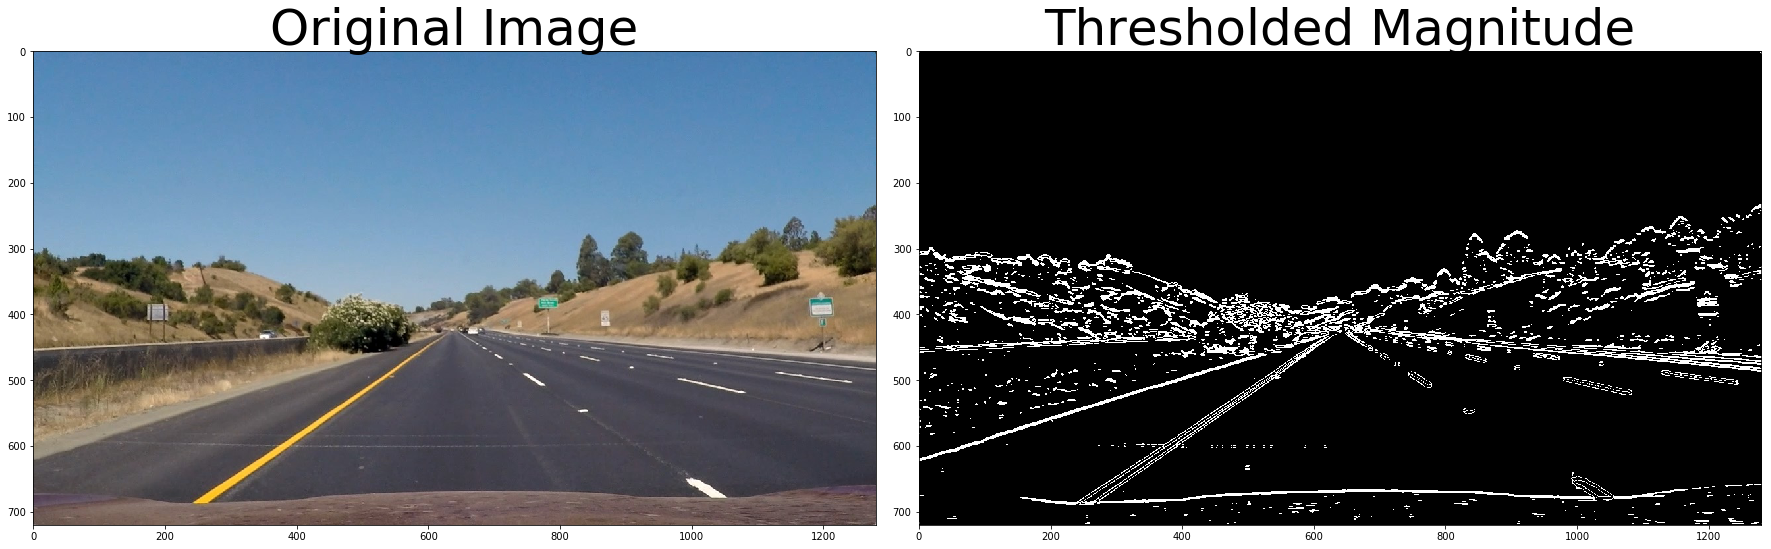

In [330]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
x_gradient_threshold = abs_sobel_thresh(image, orient ='y', sobel_kernel =9, thresh = (30,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(x_gradient_threshold, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [331]:
def mag_thresh(image, sobel_kernel = 3, mag_thresh = (0,255)):
    '''
    Using the sobel matrix to calculate gradients in both the x and y direction
    to find the magnitude of the overall gradient. 
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is.
    
    Source - Magnitude of Gradient - Udacity Course
    
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(sobel_scale)
    binary[(sobel_scale >= mag_thresh[0]) & (sobel_scale <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
    

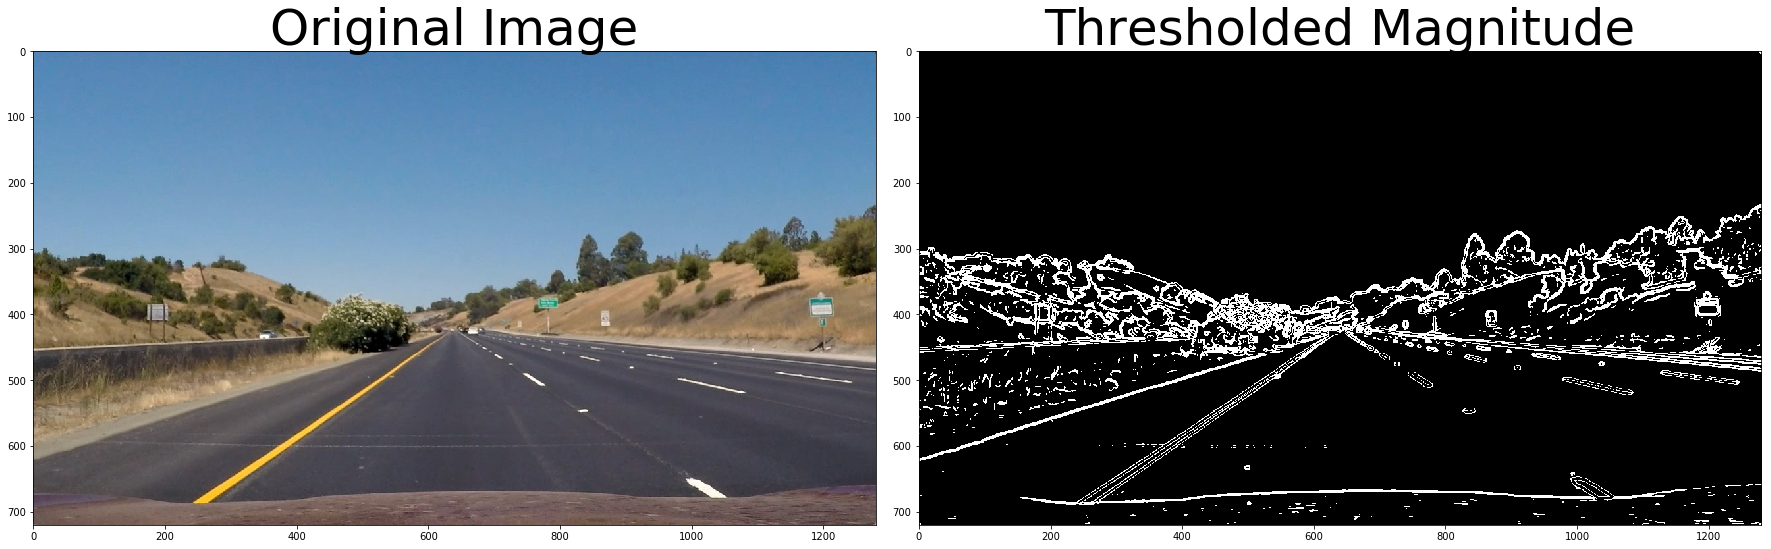

In [332]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
magnitude_threshold = mag_thresh(image, sobel_kernel =9, mag_thresh = (30,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(magnitude_threshold, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [333]:
def dir_threshold(image, sobel_kernel=3, thresh = (0, np.pi/2)):
    '''
    Using the sobel matrix to calculate gradients in both the x and y direction
    to find the magnitude of the overall gradient. 
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is. 
    
    Source - Direction of Gradient - Udacity Course
    '''
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
    
    

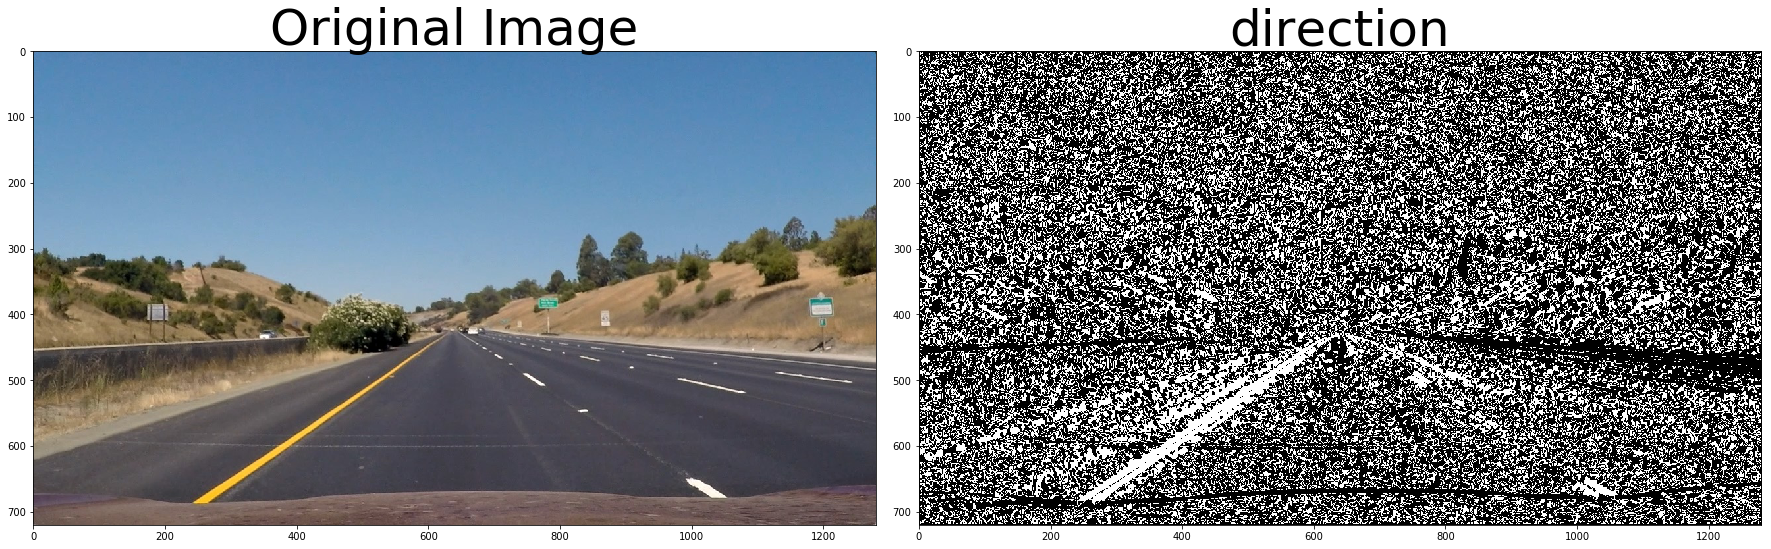

In [334]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
direction_threshold = dir_threshold(image, sobel_kernel =15, thresh = (0.8,1.3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(direction_threshold, cmap='gray')
ax2.set_title('direction', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [382]:
# Color Transforms and thresholds. Apply a threshold to S in HLS
def R_threshold(image, thresh= (200, 255)):

    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
 
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def S_threshold(image, thresh = (90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary 

def V_threshold(image, thresh = (90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    H = hls[:,:,0]
    S = hls[:,:,1]
    V = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(V > thresh[0]) & (V <= thresh[1])] = 1

    return binary 



6 binarys to combine
    - x gradients thresholded
    - y gradients thresholded
    - Gradients magnitude
    - Gradient direction
    - S in HLS threshold
    - R in RGb threshold


In [336]:
image = mpimg.imread('test_images\straight_lines2.jpg')


x_gradient_threshold = abs_sobel_thresh(image, orient ='x', sobel_kernel =9, thresh = (30,100))
y_gradient_threshold = abs_sobel_thresh(image, orient ='y', sobel_kernel =9, thresh = (30,100))
magnitude_threshold = mag_thresh(image, sobel_kernel =9, mag_thresh = (30,100))
direction_threshold = dir_threshold(image, sobel_kernel =15, thresh = (0.7,1.3))
R_thresh = R_threshold(image, thresh = (200, 255) )
S_thresh = S_threshold(image, thresh = (90, 255))

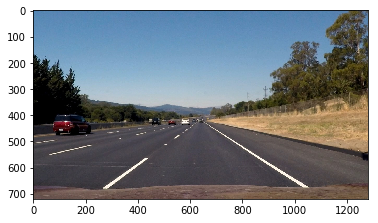

In [337]:
plt.imshow(image)

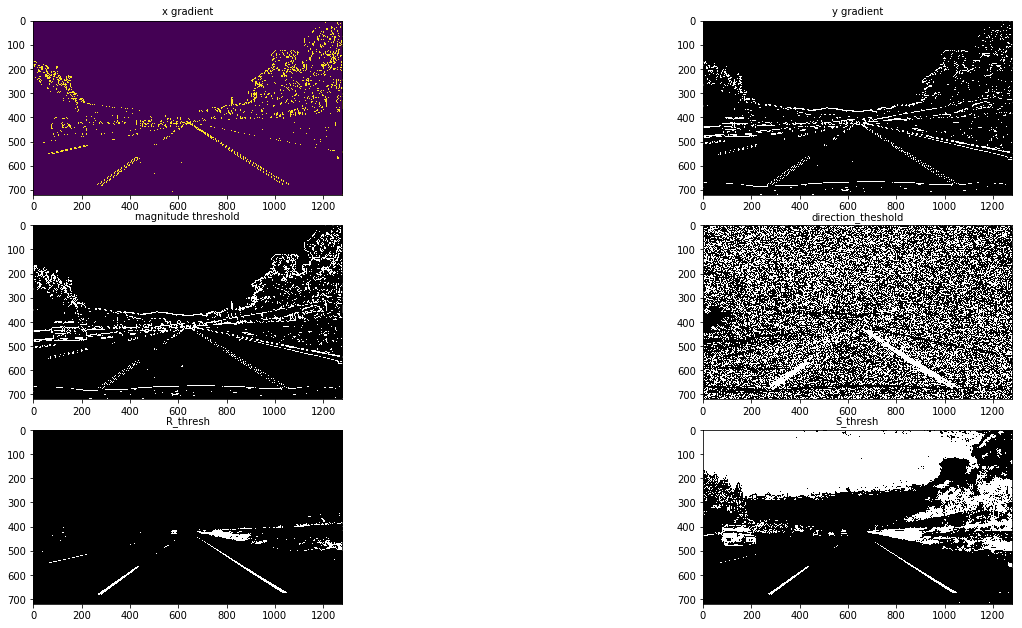

In [619]:
f, ((ax1, ax2 ), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(x_gradient_threshold)
ax1.set_title('x gradient', fontsize=10)
ax2.imshow(y_gradient_threshold, cmap='gray')
ax2.set_title('y gradient', fontsize=10)
ax3.imshow(magnitude_threshold, cmap='gray')
ax3.set_title('magnitude threshold', fontsize=10)
ax4.imshow(direction_threshold, cmap='gray')
ax4.set_title('direction_theshold', fontsize=10)
ax5.imshow(R_thresh, cmap='gray')
ax5.set_title('R_thresh', fontsize=10)
ax6.imshow(S_thresh, cmap='gray')
ax6.set_title('S_thresh', fontsize=10)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig(r'write_up_images\binary_exploration.jpg')

Now that I have all of these 6 which ones shall i combine to give me the best output.

So we can tweak the thresholds and then we can combine different ones. Trial and error to find a decent combination

I've decided that direction threshold is too noisy and that magnitude threshold doesn't add enough extra. (For now!)

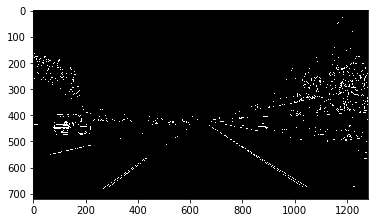

In [339]:
# How to combine

# Combine the two binary thresholds
combined_binary = np.zeros_like(x_gradient_threshold)
combined_binary[((x_gradient_threshold == 1) | 
                (y_gradient_threshold == 1) ) &
                ((R_thresh == 1) |
                (S_thresh == 1)) 
               ] = 1

plt.imshow(combined_binary, cmap='gray')


# Section 3 - Perspective Transform

In [539]:

corner_locations1x = 590
corner_locations2x = 690
corner_locations3x = 1050
corner_locations4x = 250

corner_locations1y = 450
corner_locations2y = 450
corner_locations3y = 690
corner_locations4y = 690

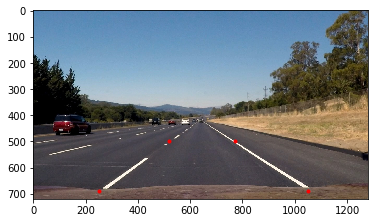

In [616]:
# Find the corners for the transform
image = mpimg.imread('test_images\straight_lines2.jpg')
plt.imshow(image)

corner_locations1x = 520.0
corner_locations2x = 770
corner_locations3x = 1050
corner_locations4x = 250

corner_locations1y = 500.0
corner_locations2y = 500
corner_locations3y = 690
corner_locations4y = 690

plt.plot(corner_locations1x,corner_locations1y,'.',color='r')
plt.plot(corner_locations2x,corner_locations2y,'.',color='r')
plt.plot(corner_locations3x,corner_locations3y,'.',color='r')
plt.plot(corner_locations4x,corner_locations4y,'.',color='r')

plt.savefig('write_up_images\source_locations.jpg')


In [541]:
def perspective_transform(image, corners):
    offset = 200
    img_size = (image.shape[1], image.shape[0])

    #Source and destination 
    # Here I need to manually get the four corners of the road in 
    # one of the pictures we can assume it's the same for each picture. 
    
    source = np.float32([[corner_locations1x,corner_locations1y],
                         [corner_locations2x,corner_locations2y], 
                         [corner_locations3x,corner_locations3y], 
                         [corner_locations4x,corner_locations4y]])
    
    # I could just eyeball a rectangle in the future image. 
    destination = np.float32([[offset, 0],
                              [img_size[0]-offset, 0], 
                              [img_size[0]-offset, img_size[1]], 
                              [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(source, destination)
    # We need to get the inverse so we can change the images back later on. 
    M_inverse = cv2.getPerspectiveTransform(destination, source)
    warped = cv2.warpPerspective(image, M, img_size)
    
    return warped, M_inverse
    

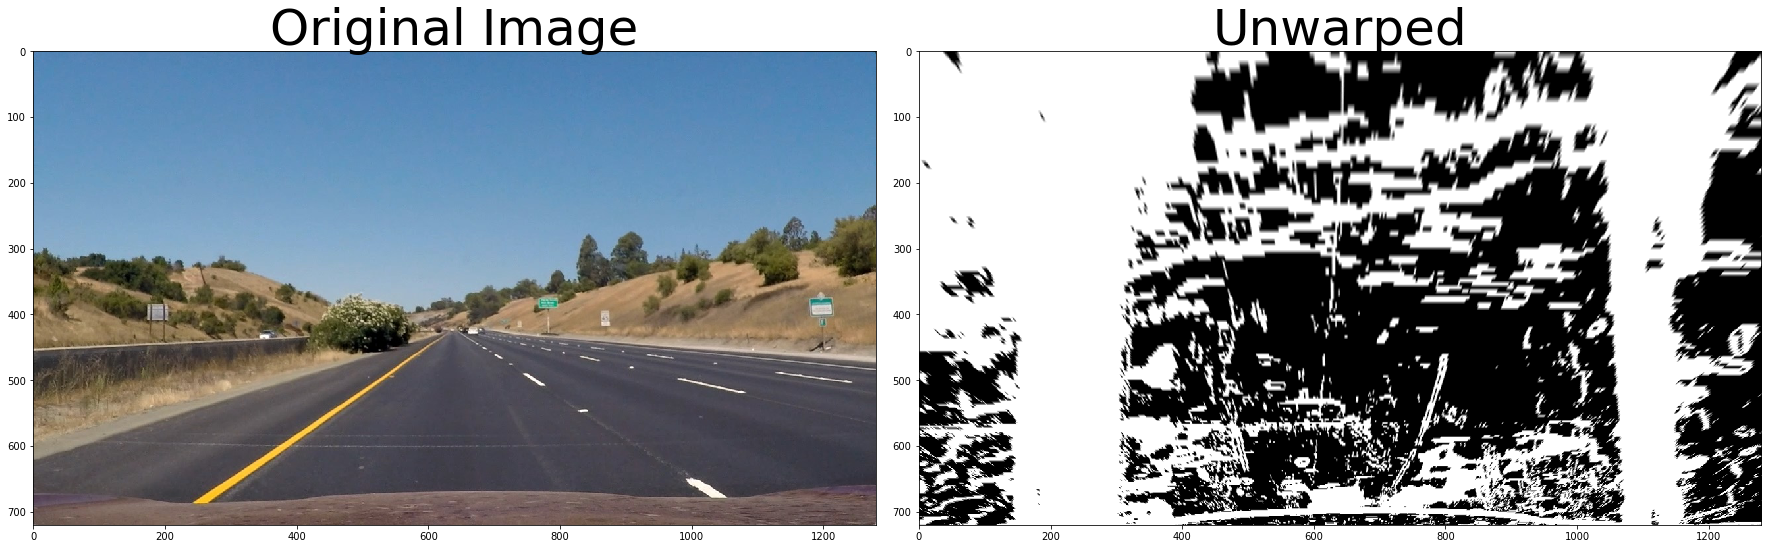

In [542]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')

warped,M_inverse = perspective_transform(combined_binary, corners)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Unwarped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Section 4 - Sliding Window to find Lanes.

- Start with the sliding window approach on the first image of the video. 
- On the subsequent images, start with the prior polyinomial.
- If the prior polinomial doesn't work - revert back to sliding window

In [543]:
# Citation - Taking the main code section here from the course content.

# Would need to then make this work for the pipeline. 

In [544]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                           
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

        
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    # Calculate the curvature in meters 
    left_curverad_m, right_curverad_m = measure_curvature_real(ploty, leftx, rightx ,lefty ,righty)

    #print('Pixel Curvature {}, {}'.format(round(left_curverad,0), round(right_curverad,0)))
    #print('Meter Curvature {}, {}'.format(round(left_curverad_m,0), round(right_curverad_m,0)))
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    return color_warp, left_curverad_m

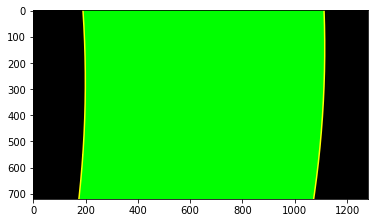

In [545]:
out_img, curve = fit_polynomial(warped)

plt.imshow(out_img)

# Section 5 - Finding the curvature

In [546]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [547]:
def measure_curvature_real(ploty, leftx, rightx ,lefty ,righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Process Each Image

In [614]:
# loop through each of the 8 test images
# Progressively add each step to assess how well it's working.

def process_image(filename):

    image = mpimg.imread('test_images/'+filename)
    # Step 1 - undistort image
    undistorted, mtx, dist = undistort_image(image, object_points, image_points)
    
    # Step 2 - Threshold the image
    x_gradient_threshold = abs_sobel_thresh(undistorted, orient ='x', sobel_kernel =3, thresh = (12,255))
    y_gradient_threshold = abs_sobel_thresh(undistorted, orient ='y', sobel_kernel =3, thresh = (25,255))
    magnitude_threshold = mag_thresh(undistorted, sobel_kernel =3, mag_thresh = (30,100))
    direction_threshold = dir_threshold(undistorted, sobel_kernel =15, thresh = (0.7,1.3))
    R_thresh = R_threshold(undistorted, thresh = (200, 255) )
    S_thresh = S_threshold(undistorted, thresh = (100, 255))
    V_thresh = V_threshold(undistorted, thresh = (60, 255))

    combined_binary = np.zeros_like(x_gradient_threshold)
    combined_binary[((x_gradient_threshold == 1)&
                (y_gradient_threshold == 1))|
                ((V_thresh == 1) &
                 (S_thresh == 1))
               ] = 255
    
    # Step 3 Perspective transform
    warped, M_inverse = perspective_transform(combined_binary, corners)
    
    out_img, left_curverad_m = fit_polynomial(warped)
    
    # Unwarp it back to the original perspective
    newwarp = cv2.warpPerspective(out_img, M_inverse, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # On this I could also output the text of the curvature
    cv2.putText(result, 'Rad of curvature left = ' +str(round(left_curverad_m,3)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    result = result
    cv2.imwrite('test_images/result_'+filename, result)
       
    # Additional lines used for one off saving for report write up.    
    #r,g,b = cv2.split((result))
    #result = cv2.merge((b,g,r))
    #cv2.imwrite('write_up_images/result_'+filename, result)

straight_lines1.jpg
straight_lines2.jpg
test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


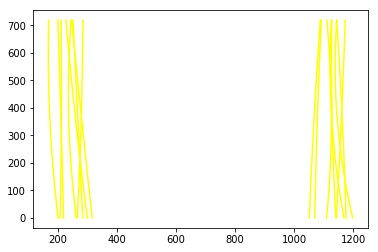

In [615]:
files = os.listdir('test_images/')
for image in files:
    if image[0:6] != 'result':
        print(image)
        process_image(image)

# Pipeline for Video



In [528]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [529]:
# Create an instance of line for left and right line
left_line = Line()
right_line = Line()

In [530]:
# Take in the video one frame at a time. Treat each frame to the correct steps

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [551]:
def process_image(image):
    '''
    Apply the pipeline to each frame in the video. Each frame is sent to this function.
    inputs
    - image The input frame. 
    - output image for each frame post all the treatment to find the lines.
    '''
    
    # Global variables we'll need.
    global mtx
    global dist
    
    
    # Step 1 - undistort image
    undistorted, mtx, dist = undistort_image(image, object_points, image_points)
    
    # Step 2 - Threshold the image
    x_gradient_threshold = abs_sobel_thresh(undistorted, orient ='x', sobel_kernel =3, thresh = (12,255))
    y_gradient_threshold = abs_sobel_thresh(undistorted, orient ='y', sobel_kernel =3, thresh = (25,255))
    magnitude_threshold = mag_thresh(undistorted, sobel_kernel =3, mag_thresh = (30,100))
    direction_threshold = dir_threshold(undistorted, sobel_kernel =15, thresh = (0.7,1.3))
    R_thresh = R_threshold(undistorted, thresh = (200, 255) )
    S_thresh = S_threshold(undistorted, thresh = (100, 255))
    V_thresh = V_threshold(undistorted, thresh = (60, 255))

    combined_binary = np.zeros_like(x_gradient_threshold)
    combined_binary[((x_gradient_threshold == 1)&
                (y_gradient_threshold == 1))|
                ((V_thresh == 1) &
                 (S_thresh == 1))
               ] = 255
    
    # Step 3 Perspective transform
    warped, M_inverse = perspective_transform(combined_binary, corners)
    
    out_img, left_curverad_m = fit_polynomial(warped)
    
    # Unwarp it back to the original perspective
    newwarp = cv2.warpPerspective(out_img, M_inverse, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # On this I could also output the text of the curvature
    cv2.putText(result, 'Rad of curvature left = ' +str(round(left_curverad_m,3)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return result

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/test_output.mp4.
Moviepy - Writing video output_images/test_output.mp4



Moviepy - Done !
Moviepy - video ready output_images/test_output.mp4
Wall time: 24min 13s


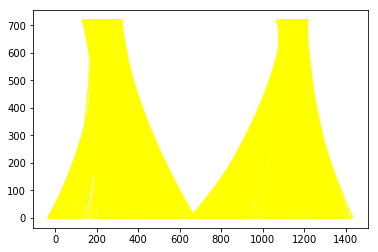

In [533]:
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile("output_images/test_output.mp4", audio=False)

In [534]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_images/test_output.mp4"))

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/test__challenge_output.mp4.
Moviepy - Writing video output_images/test__challenge_output.mp4



Moviepy - Done !
Moviepy - video ready output_images/test__challenge_output.mp4
Wall time: 9min 3s


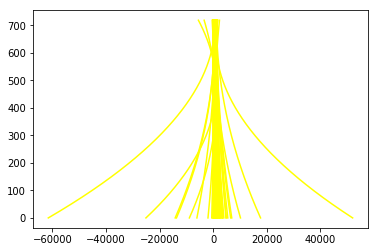

In [556]:
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile("output_images/test__challenge_output.mp4", audio=False)

In [557]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_images/test__challenge_output.mp4"))

t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/test_harder_challenge_output.mp4.
Moviepy - Writing video output_images/test_harder_challenge_output.mp4



Moviepy - Done !
Moviepy - video ready output_images/test_harder_challenge_output.mp4
Wall time: 23min 27s


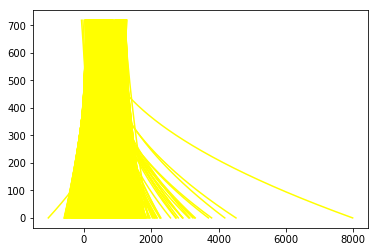

In [558]:
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile("output_images/test_harder_challenge_output.mp4", audio=False)

In [559]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_images/test_harder_challenge_output.mp4"))